# E. Usage of Trained Weight

## 실전 압축 weight 사용법

아래에서는 다른 코드를 전부 제외시키고,
App.B에서 학습시킨 weight를
읽어오는 코드만 남겨두었습니다.

## 필요한 파일 다운로드

### 모듈 다운로드

아래는 리눅스 기준으로 작성되었습니다.
만약 윈도우 등등 리눅스, git이 없는 경우에는
수동으로 아래와 같이 작업해주세요.
- https://github.com/lumiknit/mock5.py 를 다운로드 합니다.
- `mock5.py` 디렉토리에 있는 `mock5` 폴더를 복사해서 노트북과
같은 디렉토리에 둡니다.
- 최종적으로는 폴더에 다음과 같은 파일이 있어야합니다:

In [1]:
!rm -rf mock5.py
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .

Cloning into 'mock5.py'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 152 (delta 74), reused 121 (delta 47), pack-reused 0
Receiving objects: 100% (152/152), 40.18 KiB | 8.04 MiB/s, done.
Resolving deltas: 100% (74/74), done.
mv: cannot move 'mock5.py/mock5' to './mock5': Directory not empty


### Weight 다운로드

여기서는 https://github.com/lumiknit/journey-to-learn-omok
의 `app_b_last.weight`
를 `app_e.weight`라는 이름으로 다운로드 받습니다.
만약 App.B에서 학습시킨 다른 weight를 쓰고 싶다면,
마찬가지로 해당 파일을 다운로드 받아서
`app_e.weight`라는 이름으로
이 노트북과 같은 디렉토리에 두면 됩니다.

In [2]:
!rm -rf journey-to-learn-omok
!git clone https://github.com/lumiknit/journey-to-learn-omok
!mv journey-to-learn-omok/app_b_last.weight app_e.weight

Cloning into 'journey-to-learn-omok'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 238 (delta 95), reused 104 (delta 61), pack-reused 71
Receiving objects: 100% (238/238), 21.59 MiB | 12.21 MiB/s, done.
Resolving deltas: 100% (131/131), done.


최종적으로는 다음과 같은 파일이 있어야 합니다.
```
app_e_usage_of_trained_weight.ipynb
mock5.py
  * __init__.py
  * Analysis.py
  * agent_*.py
app_e.weight
```

In [3]:
!ls -lh

total 18M
-rw-r--r-- 1 root root  18M May 25 14:07 app_e.weight
drwxr-xr-x 3 root root 4.0K May 25 14:07 journey-to-learn-omok
drwxr-xr-x 3 root root 4.0K May 25 13:37 mock5
drwxr-xr-x 6 root root 4.0K May 25 14:07 mock5.py


## 모듈 불러오기

실행에 필요한 모든 모듈을 임포트하고 CUDA 등을 설정합니다.

In [4]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
import mock5.agent_random as m5rand
import mock5.agent_analysis_based as m5aa
import mock5.agent_ad as m5ad
import mock5.agent_pt as m5pt
import mock5.agent_df as m5df

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)

Device: cuda


## 보드 크기 설정

H, W를 원하는 값으로 바꾸면 됩니다.
학습은 15, 15에서 진행되었습니다.

In [5]:
H, W = 15, 15

## 신경망

Policy network의 신경망 class입니다.

In [6]:
class Flatten(nn.Module):
  def forward(self, x):
    if len(x.shape) == 3: return x.view(-1)
    else: return x.flatten(1, -1)

class Block1(nn.Module):
  def __init__(self, ch, int_ch, ker):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(ch, int_ch, ker, padding='same'),
      nn.GELU(),
      nn.Conv2d(int_ch, ch, ker, padding='same'))
    
  def forward(self, x):
    y_0 = self.seq(x)
    return nn.functional.gelu(x + y_0)

class Policy(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(2, 128, 3, padding='same'),
      nn.GELU(),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      nn.Conv2d(128, 1, 5, padding='same'),
      nn.GELU(),
      Flatten(),
      nn.LogSoftmax(dim=-1))

  def forward(self, x): return self.seq(x)

### 정책, 에이전트

Mock5 (현재 오목판)을 입력받으면
다음에 돌을 둘 위치를 행,열로 반환하는 agent를
구현합니다.

In [7]:
def fn_name(fn):
  if hasattr(fn, 'name'): return fn.name
  else: return repr(fn)

# agent: (Mock5 -> distr) -> (Mock5 -> (row, col))
# 입력은 Mock5를 입력받아서 numpy.array로 각 action을 실행할 확률 분포를 반환
# 반환값은 함수로, Mock5를 입력받아서 다음에 돌을 둘 행, 열을 정수로 반환
def agent(pi, epsilon=0):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if np.random.uniform() < epsilon or s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      else: idx = np.random.choice(h * w, p=(m / s))
    else: idx = np.random.choice(h * w, p=(p / s))
    return idx // w, idx % w
  c.name = 'stochastic({})'.format(fn_name(pi))
  return c

def game_to_tensor(game):
  t = torch.zeros(2, game.height * game.width, dtype=torch.float)
  for i in range(game.height * game.width):
    b = game.board[i]
    if b == game.player: t[0][i] = 1.0
    elif b != 0: t[1][i] = 1.0
  return t.view(2, game.height, game.width)

# policy_model: Policy -> (Mock5 -> distr)
# Policy 클래스로 된 network를 입력받아
# Mock5를 받으면 각 행동을 할 확률분포를 numpy.array로 반환하는 함수
def policy_model(net):
  def c(game):
    X = game_to_tensor(game).to(device)
    with torch.no_grad():
      p = torch.exp(net(X))
    arr = p.squeeze().to('cpu').numpy()
    return arr
  c.name = 'model({:x})'.format(id(net))
  return c

# 실제로 Policy 클래스로 행동을 확인하고 싶다면
# agent_policy(network)로도 충분합니다.
def agent_policy(net): return agent(policy_model(net))

In [8]:
# 늘 샌드백으로 쓰였던 agent_mixed
def agent_mixed(game):
  a = np.random.uniform()
  if a < 0.4: return m5aa.agent(game)
  elif a < 0.8: return m5ad.agent(game)
  elif a < 0.9: return m5pt.agent(game)
  else: return m5df.agent(game)
agent_mixed.name = 'agent-mixed-analysis-based'

## Test Agents

두 agent끼리 게임을 진행하여
승률 구합니다.
반환되는 값은, 승리 1점, 무승부 0.5점, 패배 0점으로
매겼을 때 agent1의 평균 점수입니다.

In [9]:
def test_agents(num_game, agent1, agent2, p_msg=True):
  agents = [agent1, agent2]
  w1, w2 = 0, 0
  c1, c2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    result = g.play(agents[i % 2], agents[(i + 1) % 2], random_first=False,
      print_intermediate_state=False, print_messages=False)
    if result != 0 and i % 2 == 1: result = 3 - result
    if result == 1:
      w1 += 1
      c1 += len(g.history)
    elif result == 2:
      w2 += 1
      c2 += len(g.history)
  if p_msg:
    print("-- Test Result --")
    print("* Agent1 = {} \n* Agent2 = {}".format(fn_name(agent1), fn_name(agent2)))
    print("Total : {:5d}".format(num_game))
    print("A1 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w1, w1 / num_game, c1 / max(1, w1)))
    print("A2 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w2, w2 / num_game, c2 / max(1, w2)))
  return (w1 + (num_game - w1 - w2) * 0.5) / num_game

아래를 주석을 해제하고 실행해보세요.

In [10]:
# test_agents(10, agent_mixed, m5aa.agent)
# test_agents(10, m5aa.agent, m5df.agent)
test_agents(10, agent_policy(Policy().to(device)), m5aa.agent)

-- Test Result --
* Agent1 = stochastic(model(7f78ebc2b090)) 
* Agent2 = agent-analysis-based
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov    9.7)


0.0

## Weight 불러오기

`load_hof_file`은 weight 파일에서
학습된 network를 불러와 배열로 반환합니다.
배열의 크기는 Hall of Fame의 슬롯의 개수와 같습니다.
(App.B에서는 5로 설정하여서 총 5개의 네트워크가
생깁니다.)

In [11]:
WEIGHT_FILE = 'app_e.weight'

def load_hof_file(filename):
  policies = []
  hof = torch.load(filename)
  for sl in hof['slots']:
    pi = Policy().to(device)
    pi.load_state_dict(sl['dict'])
    policies.append(pi)
  return policies

policies = load_hof_file(WEIGHT_FILE)

## Agent끼리 싸운 기보 얻기

다음과 같이 `INDEX`번째 policy와
다른 agent를 싸움을 붙여볼 수 있습니다.

 [ Turn  19 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . .
3 | . . . . . . . . . O . . . . .
4 | . . . . . . . . . O . . . . .
5 | . . . . X . X O X O . . . . .
6 | . . . . . . X O O O . . . . .
7 | . . . . . . O O X O . . . . .
8 | . . . . . . X X . X X . . . .
9 | . . . . . . . . . . . . . . .
A | . . . . . . . . . . . . . . .
B | . . . . . . . . . . . . . . .
C | . . . . . . . . . . . . . . .
D | . . . . . . . . . . . . . . .
E | . . . . . . . . . . . . . . .
1p (stochastic(model(7f78ebc391d0))) win!


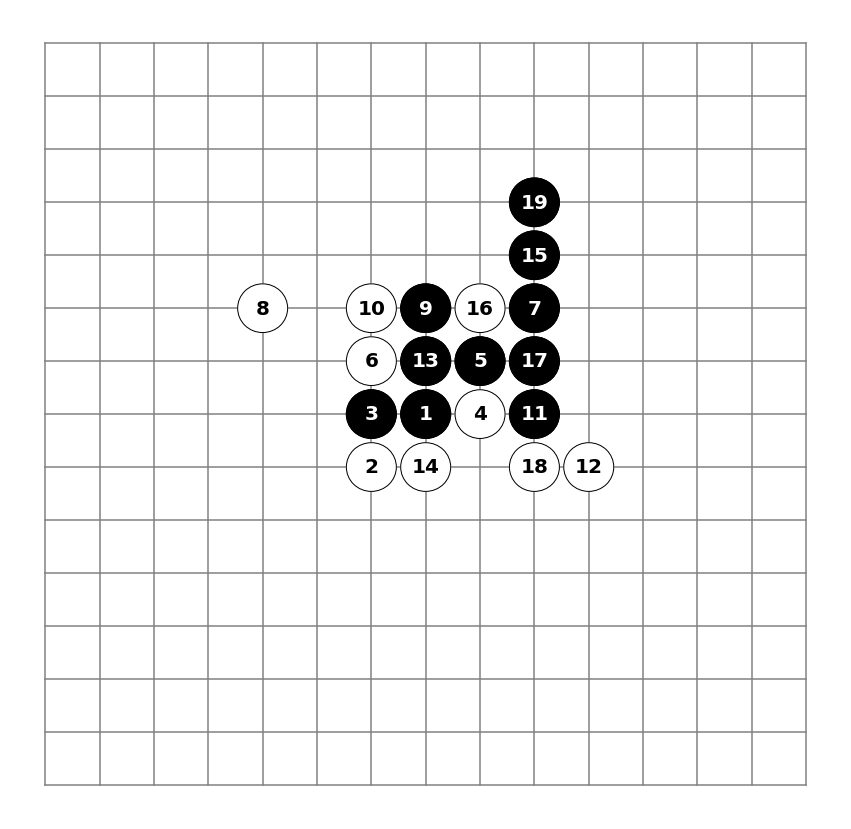

In [12]:
INDEX = 0 # Change to one of 0..len(policies)
# Create Game
m = Mock5(H, W)
# Play (policies[INDEX] v.s. m5df.agent)
m.play(
  agent_policy(policies[INDEX]), # Agent1: policies[INDEX]
  m5df.agent,                           # Agent2: algorithm
  print_intermediate_state=False)       # ONLY PRINT final state 
# Make a plot
m.plot()
plt.show()
plt.close()

## 승률 구하기

`test_agents`로 게임을 여러번 시뮬레이트 해볼 수 있습니다.

In [13]:
INDEX = 0 # Change to one of 0..len(policies)
NUM_GAME = 10
test_agents(NUM_GAME,
            agent_policy(policies[INDEX]),
            m5aa.agent)

-- Test Result --
* Agent1 = stochastic(model(7f78ebc391d0)) 
* Agent2 = agent-analysis-based
Total :    10
A1 Win:    10 (1.000) (avg.mov   21.1)
A2 Win:     0 (0.000) (avg.mov    0.0)


1.0

## 직접 플레이 해보기
agent2를 None으로 설정하면
직접 게임을 해볼 수 있습니다.
좌표는 x행 y열이면 `xy`로 입력합니다.
(e.g. 5행3열 = `53`)

In [ ]:
INDEX = 0 # Change to one of 0..len(policies)
# Create Game
m = Mock5(H, W)
# Play (policies[INDEX] v.s. m5df.agent)
m.play(
  agent_policy(policies[INDEX]), # Agent1: policies[INDEX]
  None)                                 # Agent2: User
# Make a plot
m.plot()
plt.show()
plt.close()